# Coordax Quickstart guide


**Coordax is a Python library for scientific computing in JAX. It enables users to define computation on `Field` objects that associate axes of JAX/NumPy arrays with coordinate axes.**

This tutorial provides a quick introduction to the main features:

* Coordax uses `Field` to label *Array* objects with coordinates
* Coordax enables computation on locally positional axes using `cmap` transform
* Coordax is compatbile with JAX transformations
* Coordax can be converted to and from Xarray for serialization and data analysis

# Installation

Coordax can be installed for directly from the Python Package Index:



In [1]:
! pip install -q coordax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 1.2 MB/s eta 0:00:00


In [2]:
#@title Imports { form-width: "30%" }
import warnings
warnings.simplefilter('ignore')

import dataclasses
from typing import Self

import coordax as cx
import jax
import jax.numpy as jnp
import numpy as np
import textwrap
import termcolor
import treescope
import xarray

def print_exception(e):
  name = termcolor.colored(f'{type(e).__name__}', 'red')
  print(textwrap.fill(f'{name}: {str(e)}'))


treescope.basic_interactive_setup(autovisualize_arrays=True)

# cx.Field

**Key concepts:**
* `Field` wraps *Array* data with coordinates to label data dimensions
* `Field` methods `tag`/`untag` are used to attach/remove coordinates
* *Array* dimensions labeled with `None` correspond to locally *positional* axes
* Labeled dimensions facilitate reordering and broadcasting of underlying data
* Coordinates are checked for consistency to catch alignment errors

## Instantiating `Field`

There are two ways to instantiate a `Field` object:
1. Default constructor: `Field(data: Array, dims: tuple[str, ...], axes: dict[str, Coordinate])`
2. Wrap helper method: `cx.wrap(data: Array, *coordinates: str | Coordinate)`

The later is just a syntactic sugar that ensures that dimension names and coordinate names are compatible and hence is the preferred way to instantiate `Field`.

In [3]:
data_shape = (50, 20)
rng = np.random.RandomState(0)
field_data = rng.uniform(size=data_shape)  # Example data.

x_grid = cx.DummyAxis('x', data_shape[0])  # Example coordinates.
y_grid = cx.DummyAxis('y', data_shape[1])

In [4]:
field_via_init = cx.Field(field_data, ('x', 'y'), {'x': x_grid, 'y': y_grid})
field_via_wrap = cx.wrap(field_data, x_grid, y_grid)
field_via_init, field_via_wrap

(<Field(dims=('x', 'y') shape=(50, 20), axes={}, ) (wrapping ndarray)>,
 <Field(dims=('x', 'y') shape=(50, 20), axes={}, ) (wrapping ndarray)>)

To specify an axis of a `Field` as unlabeled, we can pass `None` in place of a `Coordinate`.

In [5]:
partially_labeled_field = cx.wrap(field_data, 'x', None)
# Note: Here we pass 'x: str' instead of a Coordinate. This is implicitly
# understood as a `cx.DummyAxis` instance of appropriate size.
partially_labeled_field

<Field(dims=('x', None) shape=(50, 20), axes={}, ) (wrapping ndarray)>

When some of the axes of a `Field` are not labeled, we say that the Field has positional axes. Positional axes play a crucial role in how computation is performed on `Field` objects.

The overall shape of a `Field` is partitioned into `positional_shape` and `named_shape` properties, indicating the sizes of axes associated with each.

In [6]:
print(f'{field_via_wrap.shape=}')
print(f'{field_via_wrap.positional_shape=}')
print(f'{field_via_wrap.named_shape=}')

print(f'{partially_labeled_field.shape=}')
print(f'{partially_labeled_field.positional_shape=}')
print(f'{partially_labeled_field.named_shape=}')

field_via_wrap.shape=(50, 20)
field_via_wrap.positional_shape=()
field_via_wrap.named_shape={'x': 50, 'y': 20}
partially_labeled_field.shape=(50, 20)
partially_labeled_field.positional_shape=(20,)
partially_labeled_field.named_shape={'x': 50}


## Updating coordinate labels using `tag/untag`

To instantiate `Field` with a different set of coordinate labels from another `Field`, it is convenient to use `tag/untag` methods.

* `Field.tag` can be used on a `Field` to label all existing positional axes
* `Field.tag` can be used on a fully labeled `Field` to make provided dimensions positions

These restrictions are necessary to avoid ambiguity in which positional axis is being tagged or in which order should untagged axes appear in the `positional_shape`. Enforcing the above rules removes such ambiguity.

In [7]:
another_partially_labeled_field = field_via_wrap.untag('y')
labeled_field = partially_labeled_field.tag(y_grid)  # same as field_via_wrap

When dealing with a pytee of `Field` objects, it may be desired to relabel all entries. This can be done using simple helpers `cx.tag` and `cx.untag`.

In [8]:
tree = {
    'a': cx.wrap(np.ones((1, 1, 1)), 'x', 'y', 'z'),
    'tuple': (cx.wrap(np.array([np.pi]), 'x'), cx.wrap(np.array([np.e]), 'x')),
}
tree

{'a': <Field dims=('x', 'y', 'z') shape=(1, 1, 1) axes={} >,
 'tuple': (<Field dims=('x',) shape=(1,) axes={} >,
  <Field dims=('x',) shape=(1,) axes={} >)}

In [9]:
cx.untag(tree, 'x')

{'a': <Field dims=(None, 'y', 'z') shape=(1, 1, 1) axes={} >,
 'tuple': (<Field dims=(None,) shape=(1,) axes={} >,
  <Field dims=(None,) shape=(1,) axes={} >)}

In [10]:
cx.tag(cx.untag(tree, 'x'), 'batch')

{'a': <Field dims=('batch', 'y', 'z') shape=(1, 1, 1) axes={} >,
 'tuple': (<Field dims=('batch',) shape=(1,) axes={} >,
  <Field dims=('batch',) shape=(1,) axes={} >)}

Late we will see that a common pattern with `coordax` is to:
1. untag dimension on which we want to operate
2. perform the desired computation
3. retag the result with approriate coordinates

## Reordering, broadcasting and basic operations on `Field`

Reordering and broadcasting of `Field` objects can be done using their coordinates or dimension names.

In [11]:
f_xy = cx.wrap(np.arange(2 * 3).reshape((2, 3)), 'x', 'y')
f_yx = f_xy.order_as('y', 'x')  # transpose to a new order.

# xc, yc = cx.DummyAxis('x', 2), cx.DummyAxis('y', 3)  # also works.
# f_yx = f_xy.order_as(yc, xc)  # more on coordinate types later.
print(f'{f_xy.dims=}, {f_yx.dims=}')

f_xy.dims=('x', 'y'), f_yx.dims=('y', 'x')


In [12]:
f = cx.wrap(np.ones((4, 7)), 'x', 'y')
arange = cx.wrap(np.arange(4), 'x')
b_arange = arange.broadcast_like(f)  # broadcast to another
b_arange

<Field(dims=('x', 'y') shape=(4, 7), axes={},  [≥0, ≤3] zero:7 nonzero:21) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

Ellipsis can be used in `tag`, `order_as` operations

In [13]:
f = cx.wrap(np.ones((1, 2, 4, 3)), 'x', 'y', 'z', 'q')
f_qy = f.order_as('q', 'y', ...)
f_xq = f.untag('y', 'z')
another_f_xq = cx.wrap(np.ones((1, 2, 4, 3)), 'x', ..., 'q')
assert another_f_xq.dims == f_xq.dims
f_qy, f_xq

(<Field(dims=('q', 'y', 'x', 'z') shape=(3, 2, 1, 4), axes={}, ) (wrapping ndarray)
   <Arrayviz rendering>
 >,
 <Field(dims=('x', None, None, 'q') shape=(1, 2, 4, 3), axes={}, ) (wrapping ndarray)
   <Arrayviz rendering>
 >)

`Field` supports arithmetic operations with python numeric types (e.g. scaling)

In [14]:
cx.wrap(np.arange(5), 'x') * 2

<Field(dims=('x',) shape=(5,), axes={},  [≥0, ≤8] zero:1 nonzero:4) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

## Coordinate checks
Most manipulations on `Field` objects require exact coordinate alignment. When employing more complex coordinate objects that carry information beyond name and shape, this provides a powerful check to catch alignment and coordinate mismatch errors. In this block we will use standard `cx.SizeAxis` and `cx.LabeledAxis` coordinates to demonstrate alignment checks and will show how to implement custom coordinates in the following section.

This coordinate equality rule is relaxed for arguments passed to `tag`, `untag`, `order_as` etc. Passing a dimension name (`str`) is considered sufficient to express the user intent (assuming a coordinate with matching name is present).

In [15]:
xc, yc = cx.SizedAxis('x', 2), cx.SizedAxis('y', 3)
f_xy = cx.wrap(np.arange(xc.size * yc.size).reshape((xc.size, yc.size)), xc, yc)

f_yx = f_xy.order_as(yc, xc)  # works - we use same coordinates.
also_f_yx = f_xy.order_as('y', 'x')  # also works

x_grid = cx.LabeledAxis('x', np.linspace(0, np.pi, 2))
y_grid = cx.LabeledAxis('y', np.linspace(0, 1, 3))
try: f_xy.order_as(y_grid, x_grid)  # raises, coordinates are different
except ValueError as e: print_exception(e)

ValueError: coordinate not equal to the corresponding coordinate on
this field: coordax.LabeledAxis('y', ticks=array([0. , 0.5, 1. ])) vs
coordax.SizedAxis('y', size=3)


`cx.LabeledAxis` equality includes a check on coordinate ticks, so if coordinates differ in the exact placement of the tick values, an error is raised. This is particularly relevant for numerical methods where fields could have offsets within computational cells.

In [16]:
x_bounds, dx = np.linspace(0, 2 * np.pi, 10, endpoint=False, retstep=True)
x_centers = np.linspace(dx / 2, 2 * np.pi - dx / 2, 10)
x_grid_bounds = cx.LabeledAxis('x', x_bounds)
x_grid_centers = cx.LabeledAxis('x', x_centers)

f = cx.wrap(np.ones(10), x_grid_centers)

assert x_grid_bounds.dims == x_grid_centers.dims  # dims are the same.
assert x_grid_bounds.shape == x_grid_centers.shape  # same, compatible shape.
assert x_grid_bounds != x_grid_centers  # not equal, since tick values differ.

try: f.untag(x_grid_bounds)  # raises, coordinates are different
except ValueError as e: print_exception(e)

ValueError: coordinate not equal to the corresponding coordinate on
this field: coordax.LabeledAxis('x', ticks=array([0.        ,
0.62831853, 1.25663706, 1.88495559, 2.51327412,        3.14159265,
3.76991118, 4.39822972, 5.02654825, 5.65486678])) vs
coordax.LabeledAxis('x', ticks=array([0.31415927, 0.9424778 ,
1.57079633, 2.19911486, 2.82743339,        3.45575192, 4.08407045,
4.71238898, 5.34070751, 5.96902604]))


# cx.Coordinate

**Key concepts**
* `Coordinate` objects store coordinate-specific metadata and methods
* `Coordinate` classes are static [pytree nodes](https://docs.jax.dev/en/latest/working-with-pytrees.html#custom-pytree-nodes) which enable compile-time checks
* Users can easily define custom coordinates

`Coordinate` objects represent one or more *Array* axes, specifying their `names`, `shape` and potentially providing additional values and methods associated with the coordinate. Their core properties include:
* `dims` - tuple of dimension names
* `shape` - shape of the coordinate object
* `fields` - holds named supporting values

Lets defined a custom coordinate class:

In [17]:
@jax.tree_util.register_static
@dataclasses.dataclass(frozen=True)
class UniformAxis(cx.Coordinate):
  """Cell centered coordinate with uniform discretization of (0, `length`)."""

  name: str
  size: int
  length: float

  @property
  def dims(self):
    return (self.name,)

  @property
  def shape(self) -> tuple[int, ...]:
    return (self.size,)

  @property
  def fields(self):
    delta = self.length / self.size
    cell_centers = np.linspace(delta / 2, self.length - delta / 2, self.size)
    return {self.name: cx.wrap(cell_centers, self)}

In [18]:
z_centers = UniformAxis('z', 10, np.pi * 2)
print(z_centers)
z_centers.fields['z']  # access to supporting value from `@fields`.

UniformAxis(name='z', size=10, length=6.283185307179586)


<Field(dims=('z',) shape=(10,), axes={'z': UniformAxis}, ) (wrapping ndarray)>

In general, `Coordinate` can specify multiple dimensions. One special instance of such coordinate is a `CartesianProduct`, that simply bundles multiple `Coordinate` primitives together. It is more common to instantiate `CartesianProduct` using `cx.compose_coordinates` helper function.

In [19]:
x_axis, y_axis = UniformAxis('x', 6, np.pi), UniformAxis('y', 7, np.pi)
xy_coord = cx.compose_coordinates(x_axis, y_axis)
print(xy_coord)
print(f'{xy_coord.dims=}')
print(f'{xy_coord.shape=}')

CartesianProduct(coordinates=(UniformAxis(name='x', size=6, length=3.141592653589793), UniformAxis(name='y', size=7, length=3.141592653589793)))
xy_coord.dims=('x', 'y')
xy_coord.shape=(6, 7)


Multi-dimensional coordinates can be used the same way to `wrap`, `tag`, `untag`, etc.

In [20]:
x_axis, y_axis = UniformAxis('x', 6, np.pi), UniformAxis('y', 7, np.pi)
xy_coord = cx.compose_coordinates(x_axis, y_axis)
f = cx.wrap(np.ones((3, 6, 7)), 'batch', xy_coord)
print(f'{f.dims=}')
print(f'{f.untag(xy_coord).dims=}')

f.dims=('batch', 'x', 'y')
f.untag(xy_coord).dims=('batch', None, None)


# Computation on locally positional axes with (coordinate map) `cmap`

**Key concepts:**
* `cmap` plays a central role in connecting dimension-aware representation to array functions
* `cmap` transforms function `fn` operating on `Array` inputs to support `Field` args
* Resulting function applies `fn` over *positional axes* and vectorizes over *named axes*
* Return values have axis order determined by the order of appearance or `out_axes` kwarg
* Binary/unary operations on `Field` are implemented using `cmap`

If we have a function working with `Array` inputs that we want to apply to `Field` data, we can use the `cmap` to transform it to be compatible with `Field` arguments. Let's start with standard `jnp.add`:

In [23]:
rng = np.random.RandomState(0)
f_rand = cx.wrap(rng.uniform(size=3), 'x')
f_arange = cx.wrap(np.arange(3), 'x')
fs_added = cx.cmap(jnp.add)(f_rand, f_arange)
fs_added

<Field(dims=('x',) shape=(3,), axes={},  ≈1.6 ±0.84 [≥0.55, ≤2.6] nonzero:3) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

In the example above, `jnp.add` was vectorized over named dimension 'x' and applied to the remaining (empty) positional axes. This is reflected in the 'x' annotation of the output - vectorization over named axes preserves their coordinates.

If we pass inputs with `x` dimension untagged, the transformed function will applied to 1d arrays corresponding to the positional shape. In the case of `jnp.add`, the numerical result is the same since `jnp.add == jax.vmap(jnp.add)`.

In [22]:
added = cx.cmap(jnp.add)(f_rand.untag('x'), f_arange.untag('x'))
assert (added.data == fs_added.data).all()
added

<Field(dims=(None,) shape=(3,), axes={},  ≈1.6 ±0.84 [≥0.55, ≤2.6] nonzero:3) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

Note that `added` no longer has 'x' coordinate, since inputs had no coordinates.

Let's look at a more complex example of computing FFT over a single axis with multi-dimensional inputs

In [24]:
def fft(x):
  assert x.ndim == 1  # make sure method is applied to vectors.
  return jnp.fft.fft(x)

xc = UniformAxis('x', 16, 2 * np.pi)
rng = np.random.RandomState(0)
f_x = cx.wrap(rng.uniform(size=(3, 16, 4)), 'batch', xc, 'z')

f_kx = cx.cmap(fft)(f_x.untag(xc))
f_kx

<Field dims=(None, 'batch', 'z') shape=(16, 3, 4) axes={} >

The returned `f_kx` contains values where each 'x' slice was transformed using our function `fft`.

Note that `f_kx` has dimensions (None, 'batch', 'z'). By default, all named dimensions are vectorized and placed at the end of the result in the order in which they appear, with positional dimensions placed at the beginning of the result.

The resulting axis order can be explicitly controlled via `out_axes` argument in `cmap`, which takes a dictionary mapping axis names to their output axis indices.

Let's look at a few more example to get a feel for this behavior:

In [25]:
out = cx.cmap(fft)(f_x.order_as('z', ...).untag(xc))
assert out.dims == (None, 'z', 'batch')  # 'z', 'batch' is order of appearance.

out = cx.cmap(fft, out_axes={'batch': 0, 'z': 2})(f_x.untag(xc))
assert out.dims == ('batch', None, 'z')  # explicitly indicate out_axes order.

In the examples above `None` corresponds to the positional axis returned by `fft`. Other choice of function could reduce over the input dimension (e.g. if we replace `jnp.fft.fft` with `jnp.sum`) or could create more positional axes (e.g. `jnp.cov`). This would be reflected in the positional shape of the output (with no positional axes for `jnp.sum` and two for `jnp.cov`).

This mechanics forms the primary design pattern of locally positional axes computation:
1. Desired axes are exposed using `untag`
2. Computation is performed using `cx.cmap(fn, ...)(untagged_inputs)`
3. New coordinates are added using `tag` (if needed)

In [26]:
f_x = f_x.untag(xc)
f_kx = cx.cmap(fft, out_axes=f_x.named_axes)(f_x).tag('kx')
f_kx

<Field dims=('batch', 'kx', 'z') shape=(3, 16, 4) axes={} >

## Transforming functions with multiple arguments

`cmap` supports transforming primitives that involve multiple inputs/outputs (in fact we have already looked at the `jnp.add` example). This provides a convenient mechanism for automatic vectorization based on function inputs, but lack of care can lead to unexpected results.

Lets consider computing log likelihood (and log pdf) of a sample predicted by a model. Our function would need to accept a prediction sample and parameters of a distribution.

In [27]:
import jax.scipy.stats as jsp_stats

def log_likelihood(sample, mean, std_dev):
  log_pdf = jsp_stats.norm.logpdf(sample, loc=mean, scale=std_dev)
  return jnp.sum(log_pdf), log_pdf

samples_data = jax.random.normal(jax.random.key(0), shape=(10, 3))
samples_data = samples_data * jnp.arange(10)[:, None] + jnp.arange(10)[:, None]
samples = cx.wrap(samples_data, 'batch', 'x')

means = jnp.ones(3) * 2  # parameters of distribution
std_dev = jnp.array([1.9, 2.0, 2.1])
inputs = samples.untag('x')
ll, log_pdf = cx.cmap(log_likelihood)(inputs, means, std_dev)
ll, log_pdf

(<Field(dims=('batch',) shape=(10,), axes={},  ≈-2.4e+01 ±1.8e+01 [≥-6.2e+01, ≤-5.3] nonzero:10) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>,
 <Field(dims=(None, 'batch') shape=(3, 10), axes={},  ≈-7.9 ±9.4 [≥-4.2e+01, ≤-1.6] nonzero:30) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>)

In the example above we passed in jax.Array inputs for parameters of the distribution. We could obtain the same result by wrapping those arguments into `Field`:

In [28]:
cx.cmap(log_likelihood)(inputs, cx.wrap(means), cx.wrap(std_dev))

(<Field(dims=('batch',) shape=(10,), axes={},  ≈-2.4e+01 ±1.8e+01 [≥-6.2e+01, ≤-5.3] nonzero:10) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>,
 <Field(dims=(None, 'batch') shape=(3, 10), axes={},  ≈-7.9 ±9.4 [≥-4.2e+01, ≤-1.6] nonzero:30) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>)

However, if we accidentally pass argument with named dimension attached, the whole computation will automatically vectorize over it!

In [29]:
cx.cmap(log_likelihood)(inputs, means, cx.wrap(std_dev, 'x_axis'))

(<Field(dims=('batch', 'x_axis') shape=(10, 3), axes={},  ≈-2.4e+01 ±1.8e+01 [≥-6.5e+01, ≤-5.2] nonzero:30) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>,
 <Field(dims=(None, 'batch', 'x_axis') shape=(3, 10, 3), axes={},  ≈-7.9 ±9.2 [≥-4.2e+01, ≤-1.6] nonzero:90) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>)

## Arithmetic operations on `Field`

`Field` class implements default methods like addition, multiplication, division. These methods transform standard array methods using `cmap` and hence automatically align coordinates and broadcast data where necessary:

In [30]:
x_grid = UniformAxis('x', 5, 2*np.pi)
y_grid = UniformAxis('y', 3, 2*np.pi)

zero_field = cx.wrap(np.zeros((5, 3)), x_grid, y_grid)
ones_field = cx.wrap(np.ones((5, 3)), x_grid, y_grid)

zero_field + ones_field, zero_field * ones_field

(<Field(dims=('x', 'y') shape=(5, 3), axes={'x': UniformAxis, 'y': UniformAxis},  ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:15) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>,
 <Field(dims=('x', 'y') shape=(5, 3), axes={'x': UniformAxis, 'y': UniformAxis},  ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:15) (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: CPU 0>)

In [31]:
zero_field + ones_field.order_as('y', 'x')  # still works due to auto alignment

<Field(dims=('x', 'y') shape=(5, 3), axes={'x': UniformAxis, 'y': UniformAxis},  ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:15) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

In [32]:
zero_field.order_as('y', 'x') + ones_field  # works, but note y, x result order.

<Field(dims=('y', 'x') shape=(3, 5), axes={'y': UniformAxis, 'x': UniformAxis},  ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:15) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

Vectorization over named dimension results in effective broadcasting:

In [33]:
zero_field + cx.wrap(np.arange(zero_field.named_shape['x']), 'x')

<Field(dims=('x', 'y') shape=(5, 3), axes={'x': UniformAxis, 'y': UniformAxis},  ≈2.0 ±1.4 [≥0.0, ≤4.0] zero:3 nonzero:12) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

The same gotcha about output axis order applies to arithmetic operations. For instance adding `Field` instances with trailing positional axis will move them the the first dimension as in the case of `cmap(jnp.add)`:

In [34]:
addition = zero_field.untag('y') + ones_field.untag('y')
addition  # Note how 'x' dim got moved to the end as the only vectorized axis.

<Field(dims=(None, 'x') shape=(3, 5), axes={'x': UniformAxis},  ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:15) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

# Compatibility with JAX transformations
**Key concepts:**
* `Field` is a pytree and is compatible with shape-preserving JAX transformation
* `Field` with leading positional axes are compatible with shape-altering transformations

Since `Field` is implemented as a pytree, operations like automatic differentiation, JIT are compatible out of the box.

In [35]:
def loss(x, y):
  return cx.cmap(jnp.sum)((x - y)**2).data

grad = jax.grad(loss)(cx.wrap(np.ones(5)), cx.wrap(np.zeros(5)))
also_grad = jax.jit(jax.grad(loss))(cx.wrap(np.ones(5)), cx.wrap(np.zeros(5)))
also_grad

<Field(dims=(None,) shape=(5,), axes={},  ≈2.0 ±0.0 [≥2.0, ≤2.0] nonzero:5) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

Operations that modify the shape of the pytree leaves (e.g. `jax.vmap`, `jax.lax.scan`) are also allowed, as long as they do not violate the coordinates metadata. This requirement limits their application to `Field` instances over leading positional axes, which covers most common use-cases:

1. `jax.vmap(fn_on_field)` - explicit batching
2. `jax.lax.scan(fn, fields_to_scan_over)` - scanning over `Field` entries

In [36]:
#@title Explicit vectorization with `jax.vmap`
data = np.arange(10).reshape((2, 5))
f = cx.wrap(data, None, 'y')

def identity_with_checks(x: cx.Field) -> cx.Field:
  assert x.dims == ('y',)  # under vmap `x` will be slices of `f` above.
  return x

same_as_f = jax.vmap(identity_with_checks)(f)
same_as_f

<Field(dims=(None, 'y') shape=(2, 5), axes={}, ) (wrapping ndarray)>

Note that this will raise an Error if we try to `vmap` over a labeled dimension:

In [37]:
try: jax.vmap(identity_with_checks)(f.tag('x'))
except ValueError as e: print_exception(e)

ValueError: cannot trim named dimensions when unflattening to a
NamedArray: ('x',). JAX pytree operations on NamedArray objects are
only valid when they insert new leading dimensions, or trim unnamed
leading dimensions. The sizes and positions (from the end) of all
named dimensions must be preserved. If you are using vmap or scan, the
first dimension must be unnamed.


In [38]:
#@title Scanning over `Field` entries

data = np.arange(10).reshape((2, 5))
f = cx.wrap(data, None, 'y')

def identity_body_with_checks(unused_c, x: cx.Field) -> cx.Field:
  assert x.dims == ('y',)  # under vmap `x` will be slices of `f` above.
  return None, x

_, same_as_f = jax.lax.scan(identity_body_with_checks, init=None, xs=f)
same_as_f

<Field(dims=(None, 'y') shape=(2, 5), axes={},  [≥0, ≤9] zero:1 nonzero:9) (wrapping jax.Array)
  <Arrayviz rendering>
| Device: CPU 0>

Similarly scanning over labeled dimensions is not allowed for the same reason

In [39]:
try: jax.lax.scan(identity_body_with_checks, init=None, xs=f.tag('x'))
except ValueError as e: print_exception(e)

ValueError: cannot trim named dimensions when unflattening to a
NamedArray: ('x',). JAX pytree operations on NamedArray objects are
only valid when they insert new leading dimensions, or trim unnamed
leading dimensions. The sizes and positions (from the end) of all
named dimensions must be preserved. If you are using vmap or scan, the
first dimension must be unnamed.


## `jax.tree.map` and `Field`

There are two main options how `jax.tree.map` can interact with `Field` instances:
1. Mapping over `Field` leaves by setting `is_leaf=cx.is_field` in the `map` function
2. Mapping over underlying data using the default `map` behavior

The former is a safe approach as metadata for each `Field` is explicitly taken care by the calling function.

The later, especially when performing shape modifications, should be exercised with great care.

Coordax implements shape checks to catch issues when the underlying data was modified to be no longer compatible with the coordinate labels, but erroneous transformations that result in Arrays of compatible shape cannot be identified in general.

Similar to the `jax.vmap` and `jax.lax.scan`, functions that trim or insert leading positional dimensions are supported:

In [40]:
#@title Adding new leading positional shape using jax.tree.map

data = np.arange(10).reshape((2, 5))
f = cx.wrap(data, 'x', 'y')
# note that here tree.map operates on the underlying Array values.
with_leading_axis = jax.tree.map(lambda x: x[np.newaxis, ...], f)
with_leading_axis

<Field(dims=(None, 'x', 'y') shape=(1, 2, 5), axes={}, ) (wrapping ndarray)>

In [41]:
#@title Trimming leading positional shape using jax.tree.map

data = np.arange(10).reshape((1, 2, 5))
f = cx.wrap(data, None, 'x', 'y')
without_leading_axis = jax.tree.map(lambda x: x[0, ...], f)
without_leading_axis

<Field(dims=('x', 'y') shape=(2, 5), axes={}, ) (wrapping ndarray)>

In [42]:
#@title Modifying data without changing shape using jax.tree.map

data = np.arange(4).reshape((1, 2, 2))
f = cx.wrap(data, 'b', 'x', 'y')
double_f = jax.tree.map(lambda x: x * 2, f)
double_f

<Field(dims=('b', 'x', 'y') shape=(1, 2, 2), axes={}, ) (wrapping ndarray)>

The function above, however, cannot be distinguished from an accidental transpose of the last 2 axes, which could result in out of sync coordinates (unless motivated by the desired computation):

In [43]:
data = np.arange(4).reshape((2, 2))
f = cx.wrap(data, 'x', 'y')
yx_f_labeled_as_xy = jax.tree.map(lambda x: x.transpose(), f)
yx_f_labeled_as_xy

<Field(dims=('x', 'y') shape=(2, 2), axes={}, ) (wrapping ndarray)>

# Lossless conversion between Xarray and Coordax
**Key concepts:**
* `to_xarray` and `from_xarray` functions allow conversion between `Field` and `xarray.DataArray` representations
* Custom coordinates need to implement serialization methods


Xarray is a tool of choice for many serialization and visualization standards. To make tapping into this ecosystem easy, Coordax provides easy and lossless (round-trip) conversion between `xarray.DataArray` and `Field`.

Let's start with a simple example:


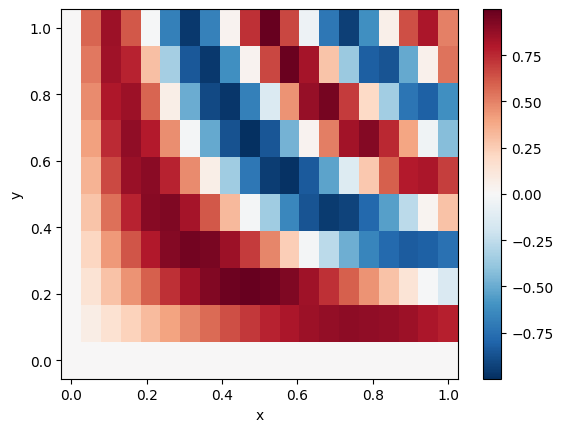

In [56]:
xc = cx.LabeledAxis('x', np.linspace(0, 1, 20))
yc = cx.LabeledAxis('y', np.linspace(0, 1, 10))

fn = lambda x, y: jnp.exp(-(x-0.5)**2) * jnp.sin(15 * x * y)
f = cx.cmap(fn)(xc.fields['x'], yc.fields['y'])
da = f.to_xarray()
da.plot(x='x', y='y')

We can restore a `Field` object from this `DataArray` if we provide appropriate coordinate types to reconstruct the objects

In [57]:
restored = cx.Field.from_xarray(da, coord_types=[cx.LabeledAxis])

We can verify that we get `f` exactly back by checking that coordinates match and that data is the same

In [58]:
assert cx.get_coordinate(f) == cx.get_coordinate(restored)
np.testing.assert_allclose(restored.data, f.data)

## Serialization of custom coordinates

How do we get back coordinates other than `cx.LabeledAxis`?

To support restoration of different coordinate objects, `Coordinate` classes can implement custom `from_xarray` method. Then, by providing candidate classes to `Field.from_xarray` (via coord_types arg), an appropriate coordinate will be instantiated.

Let us update `UniformAxis` to support conversion as an example:

In [59]:
@jax.tree_util.register_static
class UpdatedUniformAxis(UniformAxis):
  """UniformAxis with from_xarray implemented."""

  @classmethod
  def from_xarray(
      cls, dims: tuple[str, ...], coords: xarray.Coordinates
  ) -> Self | cx.NoCoordinateMatch:
    dim = dims[0]
    name = dim  # attempt to use given name.
    if coords[name].ndim != 1:
      return cx.NoCoordinateMatch('UniformAxis coordinate is not a 1D array')

    size = coords.sizes[name]
    got = coords[name].data
    steps = np.diff(got)
    if not np.allclose(np.max(steps), np.min(steps), rtol=1e-6):
      return cx.NoCoordinateMatch(
          f'UniformAxis should have uniform spacing, got {steps=}'
      )
    step = steps[0]
    if not np.allclose(got[0], step / 2):
      return cx.NoCoordinateMatch(
          f'UniformAxis ticks should start at {(step / 2)=}, {got[0]=}'
      )
    length = np.max(got) + step / 2
    return cls(name=name, length=length, size=size)

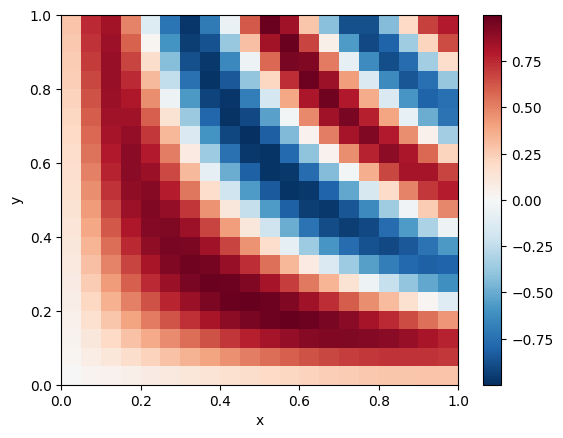

In [60]:
xc = UpdatedUniformAxis('x', 20, 1)
yc = UpdatedUniformAxis('y', 20, 1)
bc = cx.SizedAxis('batch', 4)  # add another axis.

fn = lambda x, y, b_idx: (jnp.exp(-(x-0.5)**2) * jnp.sin(15 * x * y))
f = cx.cmap(fn)(xc.fields['x'], yc.fields['y'], cx.wrap(np.ones(bc.size), bc))
da = f.to_xarray()
da.isel(batch=0).plot(x='x', y='y')

In [61]:
da

<xarray.DataArray (x: 20, y: 20, batch: 4)> Size: 6kB
array([[[ 0.0074813 ,  0.0074813 ,  0.0074813 ,  0.0074813 ],
        [ 0.02244128,  0.02244128,  0.02244128,  0.02244128],
        [ 0.03739337,  0.03739337,  0.03739337,  0.03739337],
        ...,
        [ 0.25717595,  0.25717595,  0.25717595,  0.25717595],
        [ 0.27129444,  0.27129444,  0.27129444,  0.27129444],
        [ 0.28531757,  0.28531757,  0.28531757,  0.28531757]],

       [[ 0.0234742 ,  0.0234742 ,  0.0234742 ,  0.0234742 ],
        [ 0.07034835,  0.07034835,  0.07034835,  0.07034835],
        [ 0.11699998,  0.11699998,  0.11699998,  0.11699998],
        ...,
        [ 0.6952839 ,  0.6952839 ,  0.6952839 ,  0.6952839 ],
        [ 0.72015446,  0.72015446,  0.72015446,  0.72015446],
        [ 0.742747  ,  0.742747  ,  0.742747  ,  0.742747  ]],

       [[ 0.0407108 ,  0.0407108 ,  0.0407108 ,  0.0407108 ],
        [ 0.12177484,  0.12177484,  0.12177484,  0.12177484],
        [ 0.20176937,  0.20176937,  0.20176937,  0.20176937],
        ...,
...
        [-0.7670739 , -0.7670739 , -0.7670739 , -0.7670739 ],
        [-0.3588206 , -0.3588206 , -0.3588206 , -0.3588206 ],
        [ 0.19849695,  0.19849695,  0.19849695,  0.19849695]],

       [[ 0.28378156,  0.28378156,  0.28378156,  0.28378156],
        [ 0.72015446,  0.72015446,  0.72015446,  0.72015446],
        [ 0.8236051 ,  0.8236051 ,  0.8236051 ,  0.8236051 ],
        ...,
        [-0.34475103, -0.34475103, -0.34475103, -0.34475103],
        [ 0.22104801,  0.22104801,  0.22104801,  0.22104801],
        [ 0.684658  ,  0.684658  ,  0.684658  ,  0.684658  ]],

       [[ 0.28531754,  0.28531754,  0.28531754,  0.28531754],
        [ 0.71006423,  0.71006423,  0.71006423,  0.71006423],
        [ 0.77174115,  0.77174115,  0.77174115,  0.77174115],
        ...,
        [ 0.18232189,  0.18232189,  0.18232189,  0.18232189],
        [ 0.6545309 ,  0.6545309 ,  0.6545309 ,  0.6545309 ],
        [ 0.7920655 ,  0.7920655 ,  0.7920655 ,  0.7920655 ]]],
      dtype=float32)
Coordinates:
  * x        (x) float64 160B 0.025 0.075 0.125 0.175 ... 0.875 0.925 0.975
  * y        (y) float64 160B 0.025 0.075 0.125 0.175 ... 0.875 0.925 0.975
Dimensions without coordinates: batch

In [62]:
restored = cx.Field.from_xarray(da, coord_types=[cx.SizedAxis, UpdatedUniformAxis])
cx.get_coordinate(restored)

CartesianProduct(coordinates=(UpdatedUniformAxis(name='x', size=20, length=np.float64(1.0)), UpdatedUniformAxis(name='y', size=20, length=np.float64(1.0)), coordax.SizedAxis('batch', size=4)))

# Further sections

Stay tuned for additional examples on:
* `Field` deep dive (wrapping custom Array types and gotchas)
* `Coordinate` deep dive (multidimensional coordinate primitives and inner working)
* Sharp Bits